<a href="https://colab.research.google.com/github/Chinmaya-3141/Capstone-Project/blob/main/Capstone_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import numpy as np
from numba import cuda

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

In [ ]:
# Check if GPU is available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# Set path here, access file path changes person to person

path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/Resized Data/Resized Data_320x320'

In [ ]:
# Define the transform for the data

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load the data from the combined folder

data = ImageFolder(root=path, transform=transform)

In [ ]:
# Split the data into training and testing sets

train_data, test_data = torch.utils.data.random_split(data, [int(0.8*len(data)), len(data)-int(0.8*len(data))])

In [ ]:
# Define the data loaders

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Define the CNN model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(128 * 20 * 20, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [ ]:
# Initialize the model

model = CNNModel().to(device)

In [ ]:
# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

In [ ]:
# Time the execution of the program
start_time = time.time()
loss_change = []

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_change.append(float(running_loss))
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


# Synchronize all parallel processes
cuda.synchronize()

# Calculate time taken for each part of the parallel processing
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
# Print summary of execution time

print(f"Total time: {int(execution_time/60)} minutes {execution_time - (int(execution_time/60)*60)} seconds")

Total time: 8 minutes 48.80846095085144 seconds


In [ ]:
import matplotlib.pyplot as plt

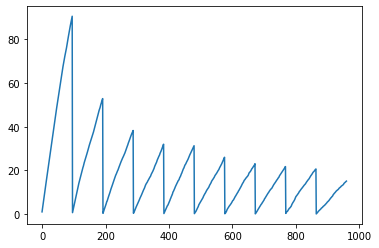

In [ ]:
plt.plot(range(960),loss_change)
plt.show()

In [ ]:
# Evaluate the model on test data

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%'% (100 * correct / total))

Accuracy of the network on the test images: 92 %
